In [14]:
import os
import json

import numpy as np
import pandas as pd
import pennylane as qml

In [21]:
folder_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\DifferentialEvolution\StatevectorFiles-Overlap\QHO"
file_paths = os.listdir(folder_path)

In [22]:
json_files = [f for f in file_paths if f.endswith('.json')]
json_files

['QHO_16.json',
 'QHO_2.json',
 'QHO_32.json',
 'QHO_4.json',
 'QHO_64.json',
 'QHO_8.json']

########################################################################
Finding optimal circuit for QHO - cutoff 16
Exact eigenvalue: 0.0
Closest energy: 0.0
Gate sequence: [{'name': 'RY', 'param': 0.0, 'wires': [0]}]
Gates needed to reach best energy: 1
Reduced circuit: [{'name': 'RY', 'param': 0.0, 'wires': [0]}]
Energy list for best circuit: [0.0]
Overlaps: [1.0]
########################################################################
Finding optimal circuit for QHO - cutoff 2
Exact eigenvalue: 0.0
Closest energy: 0.0
Gate sequence: [{'name': 'RY', 'param': 0.0, 'wires': [0]}]
Gates needed to reach best energy: 1
Reduced circuit: [{'name': 'RY', 'param': 0.0, 'wires': [0]}]
Energy list for best circuit: [0.0]
Overlaps: [1.0]
########################################################################
Finding optimal circuit for QHO - cutoff 32
Exact eigenvalue: 0.0
Closest energy: 0.0
Gate sequence: [{'name': 'RY', 'param': 0.0, 'wires': [0]}]
Gates needed to reach best energy: 1
Reduc

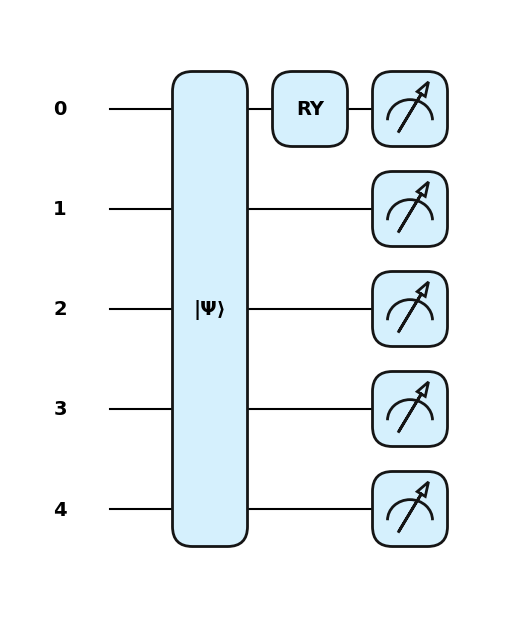

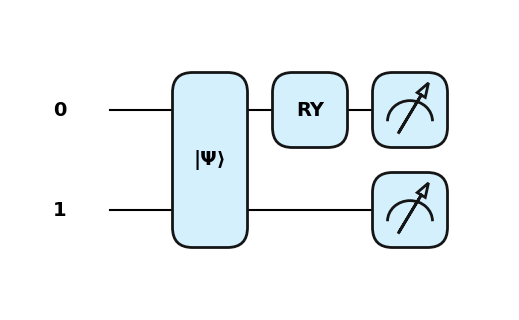

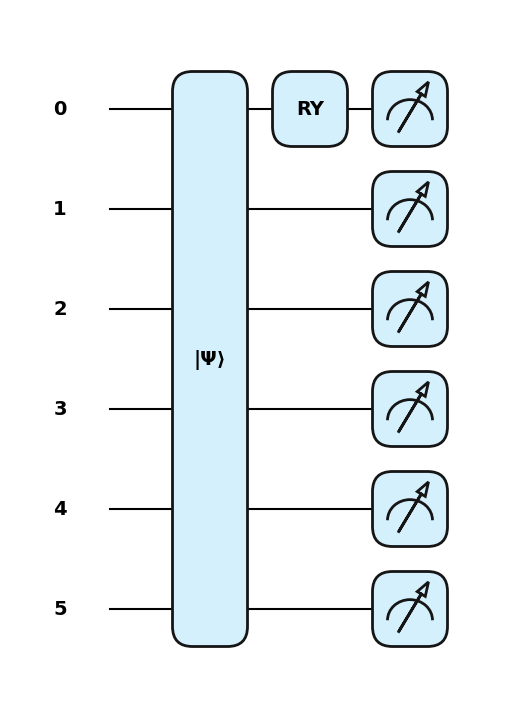

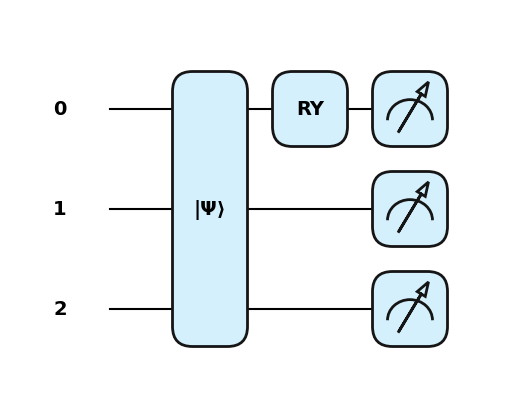

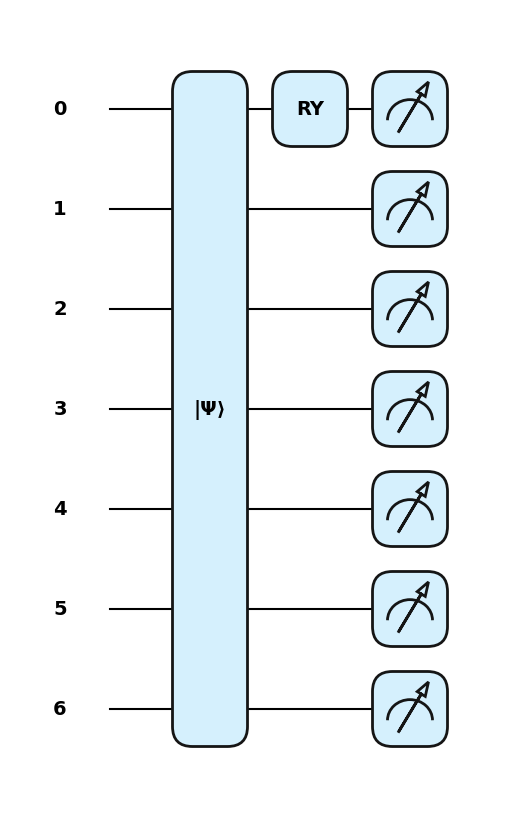

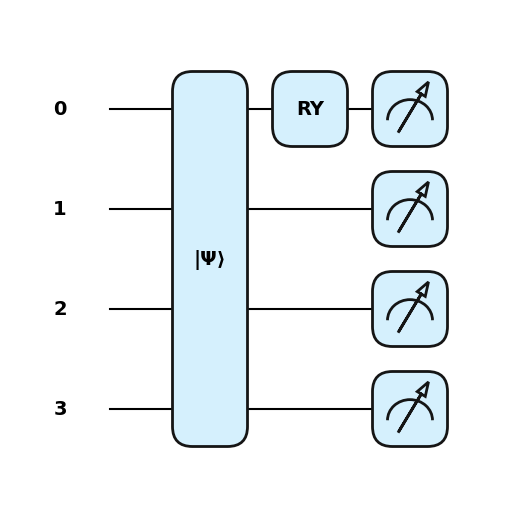

In [23]:
for file in json_files:
    
    data_path = os.path.join(folder_path,file)
    data_dict = {}

    with open(data_path, 'r') as file:
            data = json.load(file)

    cutoff = data['cutoff']
    potential = data['potential']
    energies = data['all_energies']
    overlaps = data['all_overlaps']

    print("########################################################################")
    print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

    num_qubits = int(np.log2(cutoff)) + 1
    min_eigenvalue = min(data['exact_eigenvalues'])

    closest_e = np.inf
    best_index = 0
    gate_length = np.inf
    best_energy_value = None
    best_gate_position = None

    for i, e1 in enumerate(energies):
        for g_idx, e2 in enumerate(e1, start=1):  
            ediff = abs(e2 - min_eigenvalue)

            # if closer OR equal but with fewer gates
            if ediff < closest_e or ((np.abs(ediff - closest_e) < 1e-3) and g_idx < gate_length):
            #if ediff < closest_e or (ediff == closest_e and g_idx < gate_length):
                closest_e = ediff
                best_index = i
                gate_length = g_idx
                best_energy_value = e2
                best_gate_position = g_idx

    best_gate_set = data['op_list'][best_index]
    best_gate_set_reduced = data['op_list'][best_index][:best_gate_position]

    best_energy_list = energies[best_index]
    best_energy_list_reduced = energies[best_index][:best_gate_position]

    best_overlaps = overlaps[best_index][:best_gate_position]

    print(f"Exact eigenvalue: {min_eigenvalue}")
    print(f"Closest energy: {best_energy_value}")
    print(f"Gate sequence: {best_gate_set}")
    print(f"Gates needed to reach best energy: {best_gate_position}")
    print(f"Reduced circuit: {best_gate_set_reduced}")
    print(f"Energy list for best circuit: {best_energy_list_reduced}")
    print(f"Overlaps: {best_overlaps}")


    basis_state = data["basis_state"]
    best_circuit = best_gate_set[:best_gate_position]

    data_dict = {}
    data_dict['potential'] = potential
    data_dict['cutoff'] = cutoff
    data_dict['basis_state'] = basis_state
    data_dict['min_eigenvalue'] = min_eigenvalue
    data_dict['best_energy_value'] = best_energy_value
    data_dict['best_energy_list_reduced'] = best_energy_list_reduced
    data_dict['best_overlaps'] = best_overlaps
    data_dict['circuit'] = best_circuit

    file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

    with open(file_path, "w") as file:
        json.dump(data_dict, file, indent=4)

    # Define the device
    dev = qml.device("default.qubit", wires=num_qubits)


    @qml.qnode(dev)
    def circuit():

        qml.BasisState(basis_state, wires=range(num_qubits))

        for op_dict in best_circuit:
            op = getattr(qml, op_dict["name"])
            op(op_dict['param'], wires=op_dict['wires'])

        return qml.state()

    circuit_diagram = qml.draw(circuit)()
    mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

    diagram_path = os.path.join(folder_path, "circuitDiagrams")
    os.makedirs(diagram_path, exist_ok=True)
    mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


    with open(file_path, "a", encoding="utf-8") as file:
        file.write("\n###############################\n")
        file.write(circuit_diagram)
        file.write("\n###############################\n")
